In [644]:
import json
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from math import cos, sin, tan
from time import sleep
from random import random

In [645]:
with open("car_info.json", "r") as f:
    constants = json.load(f)

m = constants["car_mass"] \
    + constants["occupant_mass"] * constants["occupant_count"] \
    + (constants["rotational_inertia_front"]+constants["rotational_inertia_back"])/constants["wheel_radius"]**2
Cdrag = constants["drag_coefficient"]
Croll = constants["rolling_resistance_coefficient"]
g = constants["gravity"]
rho = constants["air_density"]
frontal_area = constants["frontal_area"]
full_battery = constants["total_battery_energy"]

In [646]:
height = []
with open("wr_heights.json", "r") as f: #with open("HighwayCircuitHeights.json", "r") as f:  
    data = json.load(f)
    chunk_size = data[1]["distance"]-data[0]["distance"] # Chunk size is assumed constant throughout height data.
    num_chunks = len(data)
    target = full_battery*((data[-1]["distance"]+chunk_size)/1000000)
    for chunk in data:
        height.append(chunk["height"])

grad = [math.atan((height[(i+1) % num_chunks]-height[(i-1) % num_chunks])/(2*chunk_size)) for i in range(len(height))]
c = chunk_size
n = num_chunks
data[-1]["distance"]


3260

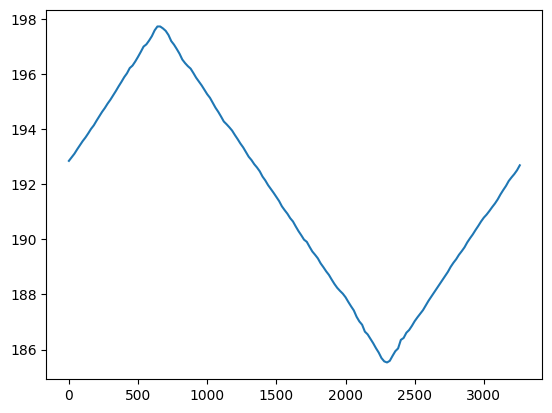

In [647]:
plt.plot([20*i for i in range(num_chunks)], height)

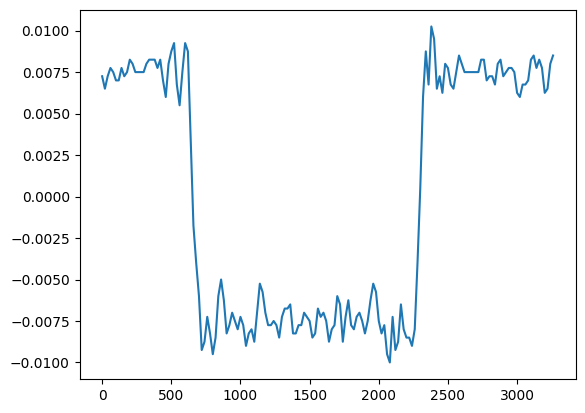

In [648]:
plt.plot([20*i for i in range(num_chunks)], grad)

Hyperparameters:

In [649]:
lamb = 0.9999
lr_max = 1
init_v = 30

In [650]:
def H_hat(v):
    return [m*v[i]*(v[(i+1)%n]-v[(i-1)%n])/(2*cos(grad[i]))+c*Cdrag*frontal_area*rho*v[i]**2/(2*cos(grad[i]))+c*Croll*m*g+c*m*g*tan(grad[i]) for i in range(n)]

In [651]:
def Error(v, s):
    return (1-lamb)*(s-target)**2/target+lamb*sum([1/vee for vee in v])

In [652]:
def Error_grads(v, s):
    return [2*(1-lamb)*(c*Cdrag*frontal_area*rho*v[i]/cos(grad[i]))*(s/target-1)-lamb/v[i]**2 for i in range(n)]

Core Gradient Descent Loop

100%|██████████| 100000/100000 [00:36<00:00, 2770.01it/s]


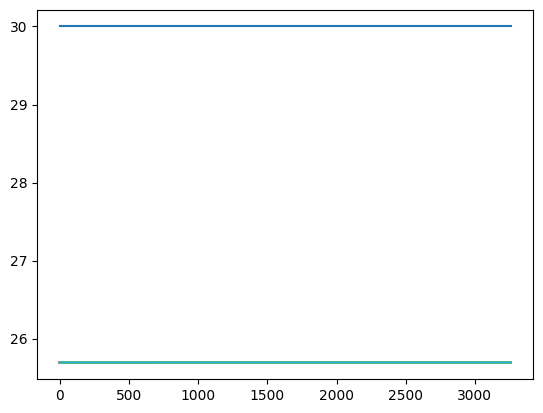

In [653]:
%matplotlib inline

v = [init_v]*num_chunks
#v = [vee+random()/10 for vee in v]

loss_history = []
v_history = []

cc = 100000
best_v = v

lr = lr_max
init_error = Error(v, sum(H_hat(v)))
best_error = init_error

for count in tqdm(range(cc)):

    if count % (cc//20) == 0: 
        plt.plot([20*i for i in range(num_chunks)], v)
        plt.show
        v_history.append(v)

    s = sum(H_hat(v))
    error = Error(v, s)

    loss_history.append(error)

    if error <= best_error:
        best_error = error
        best_v = v
    else:
        lr = lr_max*math.sqrt(error/init_error)

    if count > cc:
        break

    #if (error-best_error) > best_error*10:
    #    break

    #############
    if error < 1:
        break
    #############

    error_grads = Error_grads(v, s)
    erg_sum = sum([abs(error_grad) for error_grad in error_grads])
    v = [abs(v[i]-lr*error_grads[i]/erg_sum) for i in range(num_chunks)]
    


Best error: 6.5697147794156 
Average velocity: 92.48326696187952


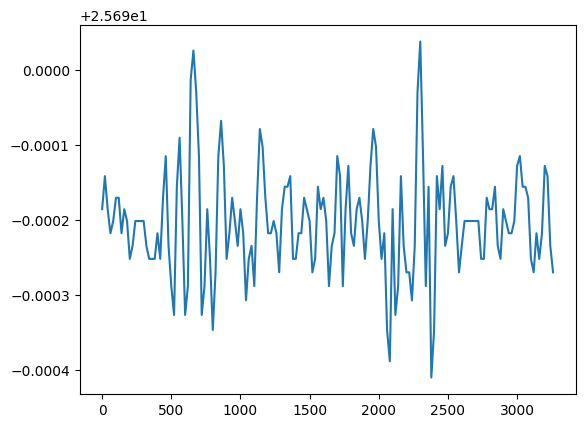

In [654]:
print("Best error:",best_error, "\nAverage velocity:", sum(best_v)/len(best_v)*3.6)
plt.plot([20*i for i in range(num_chunks)], best_v)
plt.show()

Log loss history


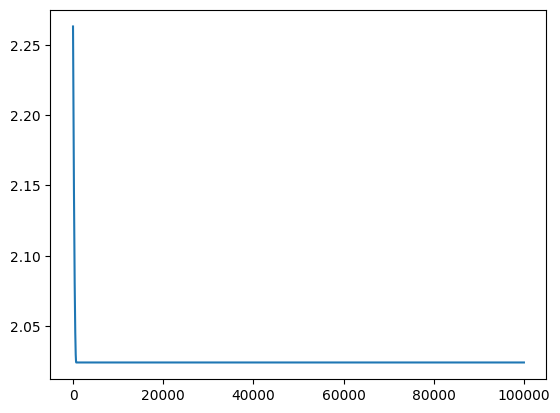

Final loop error: 6.569714784926684


In [655]:
print("Log loss history")
plt.plot([math.log(loss+1) for loss in loss_history])
plt.show()

print("Final loop error:", loss_history[-1])

In [656]:
v = best_v
h = H_hat(v)
total_lap_energy= sum(h)
print(full_battery, total_lap_energy*1000000/(n*c))

136800000.0 145619428.93505472


: 